## Articles-Comments-Ratings – Exploration

> [bonprix-challenge](https://www.bonprix.de/corporate/karriere/coding-challenge/)

### Relevant Imports

In [2]:
# Standard library imports
from collections import Counter
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize

# Local application imports
from corpora_parser import get_list_of_nouns

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

### Creating a Stopwords Set for german text

In [4]:
filename = 'german_stopwords.txt'

with open(filename, 'r', encoding="utf-8", errors='ignore') as file:

    stopwords = [word.strip() for word in file.readlines()]

de_stop_words = set(stopwords)

### Creating a list of Nouns from german corpora

In [5]:
path1 = 'SentiWS_v2.0_Negative.txt'
path2 = 'SentiWS_v2.0_Positive.txt'

other = [
    'material', 'farbe', 'preis', 'hose', 'farben', 'bh', 'stoff', 'stoffe',
    'hosen', 'preise', 'materialien', 'schuh', 'schuhe', 'artikel', 'kleid',
    'kleider'
]

nouns1 = get_list_of_nouns('SentiWS_v2.0_Negative.txt')
nouns2 = get_list_of_nouns('SentiWS_v2.0_Positive.txt')
nouns = nouns1 + nouns2
nouns = [element.lower() for element in nouns]

nouns = nouns + other

### Loading the data

In [6]:
df = pd.read_csv('Datensatz_Coding_Challenge.csv', encoding='latin-1', sep=';')
df.head()

,StyleID,text,rating
0,1709054,Die sind okay und dann für den Preis.,5
1,1709054,"Qualität und Preis sind gut. Leider sind sie zu groß. Die Größen fallen immer unterschiedlich aus, sodaß es bei dem einen Shirt paßt und bei dem anderen nicht. Schade",3
2,8623725,lässt schlanker aussehen,5
3,8623725,"Material und Farbe gut. Da einige Kundinnen in der Bewertung über relative Enge geklagt hatten, wählte ich eine Konfektionsgröße höher(44). Leider war der Badeanzug um den Po herum zu weit, kein schöner Abschluss. Ich habe ihn zurück geschickt.",3
4,9743730,Material ist schön zum verdunkel. Leider doch zu kurz für mein Fenster. Schade.,5


### Mapping dummy names for products instead if IDs and computing the average rating per Product

In [7]:
ids = sorted(list(set(df.StyleID.values)))
mapping = {ids[i]: 'article Nr.{}'.format(i) for i in range(len(ids))}
df.StyleID = df.StyleID.map(mapping)

avg_rating_per_id = round(df.groupby('StyleID').rating.mean(), 2)
avg_rating = avg_rating_per_id.values.tolist()
avg_rating_df = pd.DataFrame({'article': ids, 'rating': avg_rating})
avg_rating_df.head()

,article,rating
0,434886,4.13
1,515928,4.63
2,553018,4.06
3,654563,4.01
4,655046,4.16


### Three ways of getting total counts per rating

In [8]:
val_cnt_df = df.copy()
val_cnt_df.rating = pd.Categorical(val_cnt_df.rating, categories=[1, 2, 3, 4, 5])
ratings_df = val_cnt_df.rating.value_counts().to_frame().reset_index().sort_values(by=['index'], ascending=False)
ratings_df.columns = ['rating', 'count']
ratings_df

,rating,count
0,5,9879
1,4,5677
2,3,1640
4,2,763
3,1,1191


In [9]:
n, _, _ = plt.hist(df.rating, bins=5)  # bins, patches
plt.clf()
count = [*map(lambda x: int(x), n)]
rating = [*range(1, len(n) + 1)]

total_rating_df = pd.DataFrame({'rating': rating, 'count': count})

<Figure size 432x288 with 0 Axes>

In [10]:
total_ratings = df.copy()
total_ratings = total_ratings.drop('text', axis=1)
total_ratings = total_ratings.groupby('rating').count()
total_ratings.columns = ['count']
total_ratings.reset_index()
total_ratings

,count
rating,
1,1191
2,763
3,1640
4,5677
5,9879


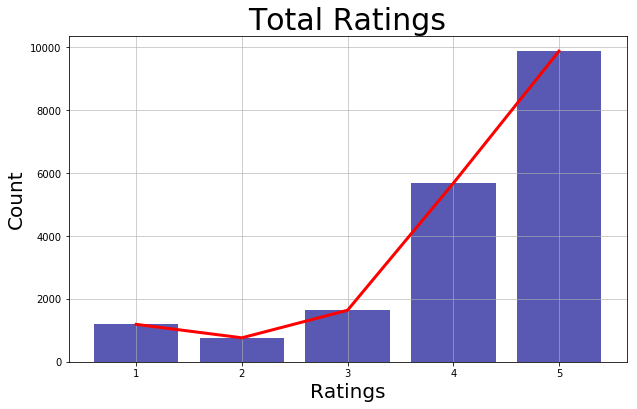

In [11]:
_ = plt.figure(figsize=(10, 6))
_ = plt.grid(alpha=0.75)
_ = plt.xlabel("Ratings", fontsize=20)
_ = plt.ylabel("Count", fontsize=20)
_ = plt.title("Total Ratings", fontsize=30)
_ = plt.bar(x=total_ratings.index,
            height=total_ratings['count'],
            color='darkblue',
            alpha=0.65)
_ = plt.plot(total_ratings['count'], color='red', linewidth=3)
plt.show()

### Creating dataframes of articles and ratings for plotting purposes

In [12]:
dataframes = [
    df.query('StyleID == "article Nr.{}"'.format(i)) for i in range(len(ids))
]

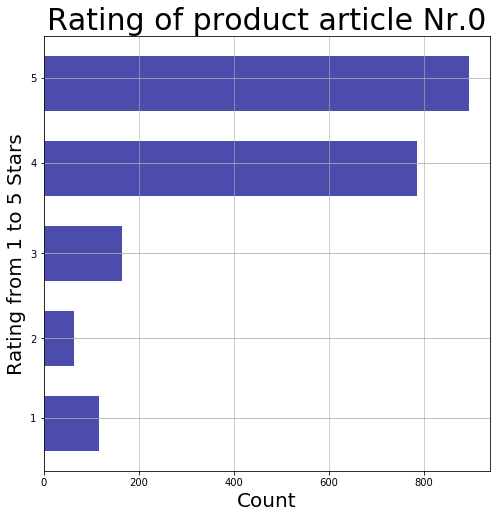

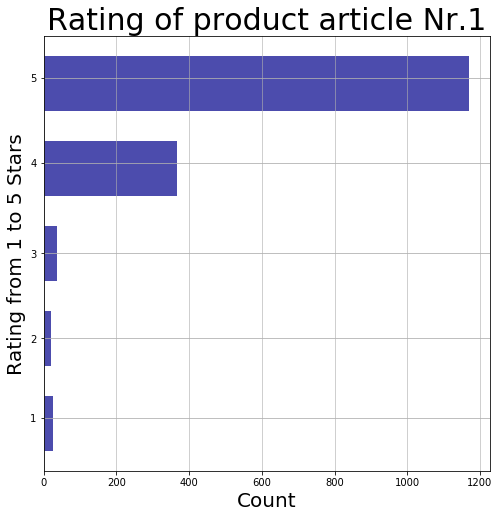

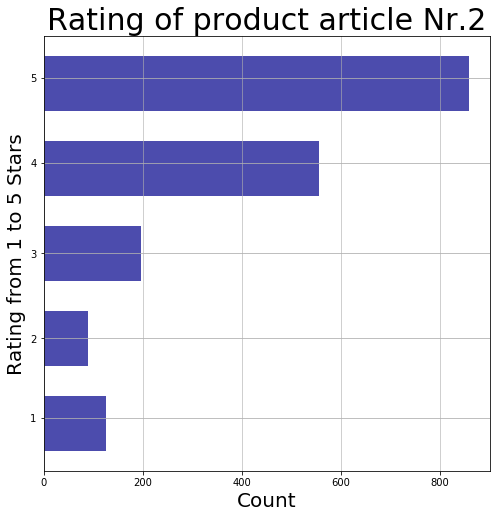

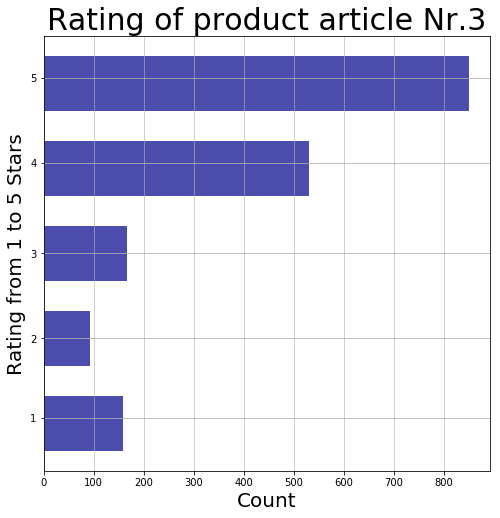

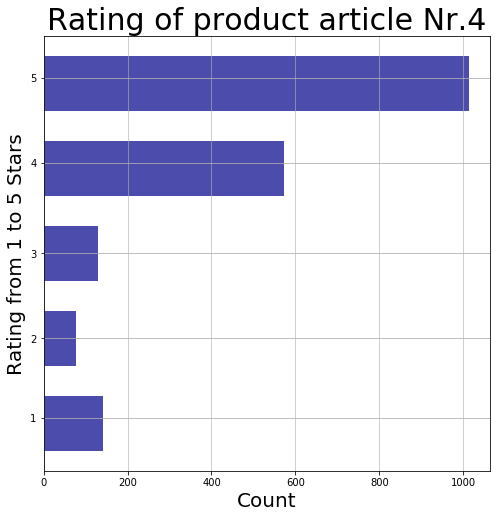

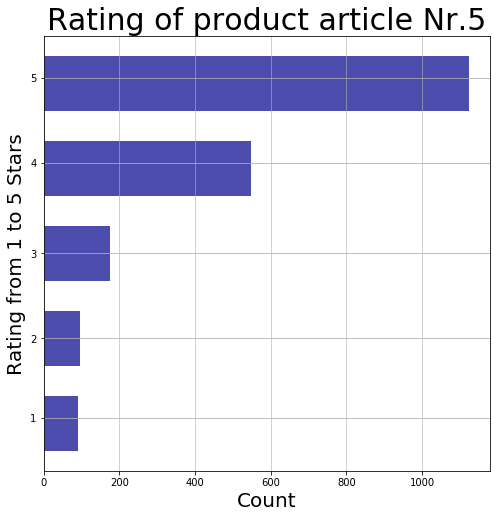

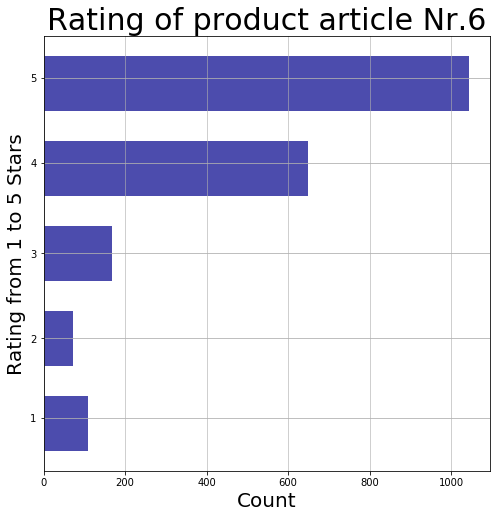

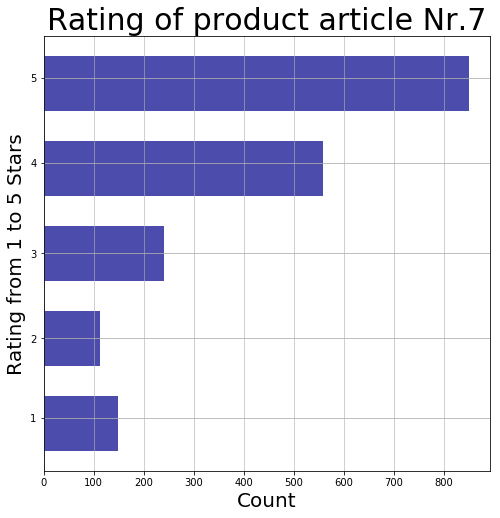

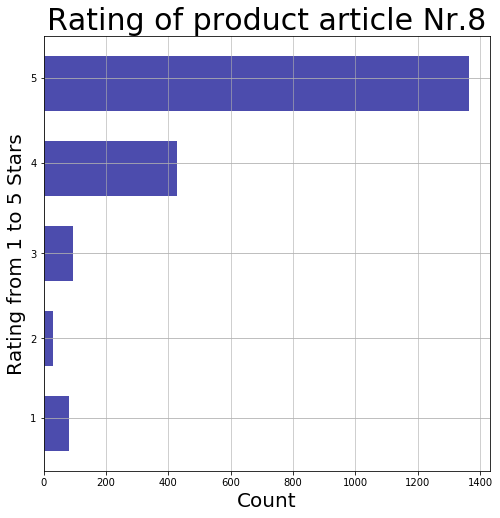

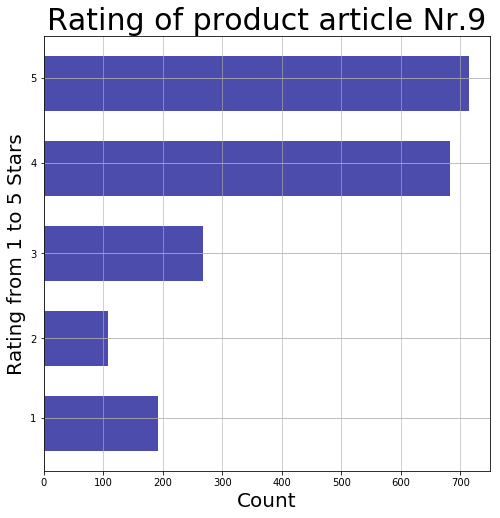

In [13]:
for i in range(len(ids)):
    current_article = dataframes[i].StyleID.values.tolist()[0]
    _ = dataframes[i].hist(bins=5,
                           orientation='horizontal',
                           rwidth=0.65,
                           alpha=0.7,
                           color='darkblue',
                           align='mid',
                           figsize=(8, 8))

    _ = plt.grid(axis='x', alpha=0.75)
    _ = plt.yticks([1.45, 2.20, 3.00, 3.85, 4.65], [1, 2, 3, 4, 5])
    _ = plt.ylabel('Rating from 1 to 5 Stars', fontsize=20)
    _ = plt.xlabel('Count', fontsize=20)
    _ = plt.title('Rating of product {}'.format(current_article), fontsize=30)

    plt.show()

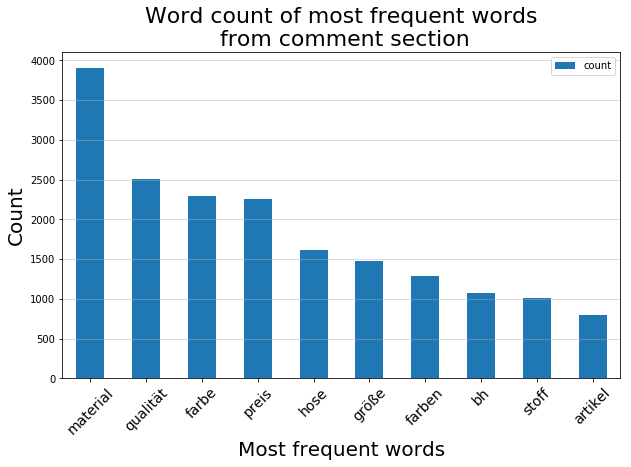

In [14]:
# nltk.download('punkt')
sentences = [word_tokenize(sentence) for sentence in df.text]

words = [
    word.lower() for sentence in sentences for word in sentence
    if not word.lower() in de_stop_words
]

final_words = [word for word in words if word in nouns]

top_ten = Counter(final_words).most_common(10)

top_ten_df = pd.DataFrame(top_ten, columns=['word', 'count'])
_ = top_ten_df.plot(x='word', y='count', kind='bar', figsize=(10, 6))
_ = plt.grid(axis='y', alpha=0.55)
_ = plt.xticks(rotation=45, fontsize=14)
_ = plt.title('Word count of most frequent words\n from comment section',
              fontsize=22)
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xlabel('Most frequent words', fontsize=20)


plt.show()

### Presentation of a threshold - only words beyond the threshold will go in the later word cloud

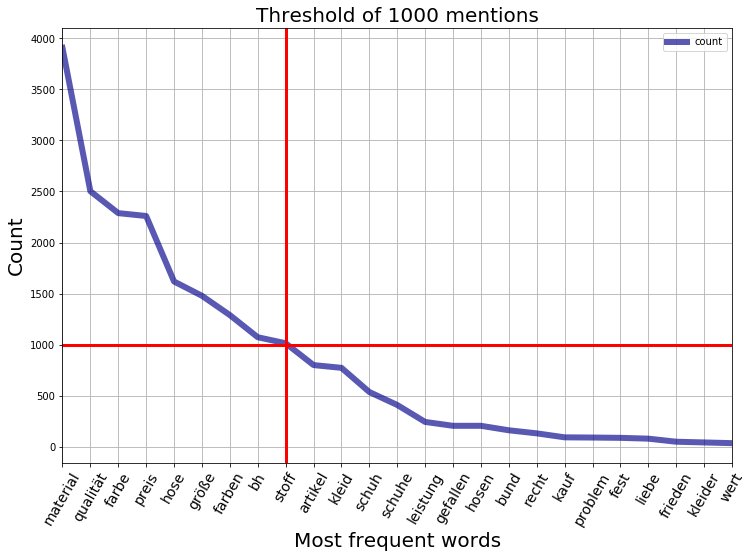

In [15]:
freqdist = nltk.FreqDist(final_words)
y_threshold = 1000

over_thousand = [key for key, value in freqdist.items() if value > y_threshold]
x_threshold = len(over_thousand) - 1

most_common = freqdist.most_common(25)
data = pd.DataFrame(most_common, columns=["word", "count"])

ax = data.plot(x='word',
               y='count',
               kind='line',
               linewidth=6,
               color='darkblue',
               alpha=0.65,
               figsize=(12, 8))
ax.axhline(y=y_threshold, color='red', linewidth=3)
ax.axvline(x=x_threshold, color='red', linewidth=3)
ax.grid(True)
ax.set_title("Threshold of 1000 mentions", fontsize=20)
ax.set_xlabel('Most frequent words', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_xticks(list(data.index))
ax.set_xticklabels(data.word.values.tolist(), rotation=60, fontsize=14)

plt.show()